In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

### Importing saved metrics JSON files

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist, or the JSON is
    not well-formed.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    try:
        with open(path, "r") as f:
            return json.load(f)
    except json.JSONDecodeError:
        print("Metrics JSON at %s is not well-formed" % path)

In [3]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func, max_epoch=None):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return True if the _first_ one is better. If `max_epoch` is provided, will only
    report everything up to this epoch (1-indexed).
    Returns the number of the run, the (one-indexed) number of the epoch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                if i == max_epoch:
                    break
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception as e:
            print(e)
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

### Profile models

In [4]:
def print_profile_losses(models_path, max_epoch=None):
    """
    Given the path to a condition containing many runs, prints out the best validation
    profile NLL losses for each run, and the set of profile NLL losses for training
    and validation over all epochs, as well as the validation prior loss. If given,
    only consider up to `max_epoch` epochs total; anything afterward would be ignored.
    """
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [5]:
profile_models_path = "/users/amtseng/att_priors/models/trained_models/profile/"

In [6]:
noprior_prof_val_losses = print_profile_losses(os.path.join(profile_models_path, "K562"))

Best profile loss overall:
	Best run: 10
	Best epoch in run: 19
	Associated value: 1255.4317541029848
Best epoch in each run:
	Run 1, epoch 17: 1262.15
	Run 2, epoch 19: 1268.89
	Run 3, epoch 17: 1261.35
	Run 4, epoch 20: 1258.88
	Run 5, epoch 19: 1265.38
	Run 6, epoch 17: 1255.45
	Run 7, epoch 20: 1266.63
	Run 8, epoch 20: 1262.69
	Run 9, epoch 18: 1262.78
	Run 10, epoch 19: 1255.43
	Run 11, epoch 11: 1263.93
	Run 12, epoch 18: 1268.99
All validation profile and prior losses:
1
	2401.36 1853.28 1644.15 1521.54 1439.16 1364.68 1348.58 1315.18 1281.21 1261.06 1249.43 1237.09 1229.52 1214.45 1211.05 1200.57 1192.88 1193.27 1186.49 1180.36
	1789.37 1519.42 1491.82 1355.95 1331.72 1306.93 1318.51 1296.01 1285.58 1278.34 1271.78 1272.45 1279.46 1273.25 1267.78 1265.45 1262.15 1265.46 1273.17 1274.47
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	2049.23 1691.54 1530.40 1427.21 1380.95 1334.04 13

In [7]:
prior_prof_val_losses = print_profile_losses(os.path.join(profile_models_path, "K562_prior"))

Best profile loss overall:
	Best run: 5
	Best epoch in run: 18
	Associated value: 1264.7475971110816
Best epoch in each run:
	Run 1, epoch 20: 1266.43
	Run 2, epoch 13: 1277.83
	Run 3, epoch 19: 1273.79
	Run 4, epoch 16: 1270.23
	Run 5, epoch 18: 1264.75
All validation profile and prior losses:
1
	2139.00 1784.31 1576.52 1478.16 1413.09 1358.24 1329.71 1303.41 1287.20 1271.63 1262.31 1249.70 1245.03 1234.22 1230.65 1223.94 1219.55 1212.95 1211.06 1212.59
	1702.08 1523.01 1421.21 1349.81 1321.94 1305.91 1293.96 1297.29 1307.92 1296.85 1281.18 1271.99 1275.55 1322.68 1281.59 1278.22 1284.10 1267.04 1270.59 1266.43
	0.2253 0.1612 0.1326 0.1145 0.1138 0.1038 0.1028 0.1001 0.0985 0.0951 0.0927 0.0908 0.0874 0.0854 0.0878 0.0897 0.0839 0.0843 0.0847 0.0852
2
	2074.76 1694.66 1573.76 1465.29 1397.94 1353.74 1322.74 1312.13 1282.93 1279.53 1260.35 1255.13 1242.60 1234.00 1230.15
	1612.40 1452.94 1425.35 1347.95 1332.54 1307.14 1313.30 1303.22 1281.20 1279.56 1292.30 1280.00 1277.83 1280.66 129

Mean without priors: 1262.712578
Mean with priors: 1270.605335
One-sided t-test p: 0.003501


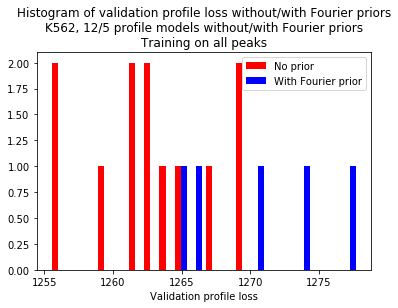

In [9]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_prof_val_losses.values())), np.array(list(prior_prof_val_losses.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"])
title = "Histogram of validation profile loss without/with Fourier priors"
title += "\nK562, %d/%d profile models without/with Fourier priors" % (len(noprior_prof_val_losses), len(prior_prof_val_losses))
title += "\nTraining on all peaks"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_prof_val_losses.values())), np.array(list(prior_prof_val_losses.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print("Mean without priors: %f" % np.mean(np_vals))
print("Mean with priors: %f" % np.mean(p_vals))
print("One-sided t-test p: %f" % (p / 2))

### Binary models

In [12]:
def print_binary_losses(models_path, max_epoch=None):
    """
    Given the path to a condition containing many runs, prints out the best validation
    losses for each run, and the set of losses for training and validation over all
    epochs, as well as the validation prior loss. If given, only consider up to
    `max_epoch` epochs total; anything afterward would be ignored.
    """
    print("Best validation loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y,
        max_epoch
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.3f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["train_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_corr_losses"]["values"], axis=1)[:max_epoch]]))
        print("\t" + " ".join(["%6.3f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)[:max_epoch]]))
    return all_vals

In [5]:
binary_models_path = "/users/amtseng/att_priors/models/trained_models/binary/"

In [14]:
noprior_bin_val_losses = print_binary_losses(os.path.join(binary_models_path, "SPI1_keep1"))

Best validation loss overall:
	Best run: 11
	Best epoch in run: 2
	Associated value: 0.5065109473611508
Best epoch in each run:
	Run 1, epoch 2:  0.524
	Run 2, epoch 2:  0.519
	Run 3, epoch 2:  0.532
	Run 4, epoch 2:  0.513
	Run 5, epoch 2:  0.541
	Run 6, epoch 2:  0.527
	Run 7, epoch 2:  0.518
	Run 8, epoch 2:  0.518
	Run 9, epoch 2:  0.534
	Run 10, epoch 2:  0.537
	Run 11, epoch 2:  0.507
	Run 12, epoch 2:  0.547
	Run 13, epoch 2:  0.559
	Run 14, epoch 2:  0.530
	Run 15, epoch 2:  0.531
	Run 16, epoch 2:  0.517
	Run 17, epoch 2:  0.512
	Run 18, epoch 2:  0.512
	Run 19, epoch 2:  0.515
	Run 20, epoch 2:  0.550
	Run 21, epoch 2:  0.518
	Run 22, epoch 2:  0.528
	Run 23, epoch 2:  0.508
	Run 24, epoch 2:  0.526
	Run 25, epoch 3:  0.540
	Run 26, epoch 2:  0.525
	Run 27, epoch 2:  0.520
	Run 28, epoch 2:  0.525
	Run 29, epoch 2:  0.542
	Run 30, epoch 1:  0.593
All validation profile and prior losses:
1
	 0.570  0.286  0.153  0.103  0.073
	 0.586  0.524  0.553  0.580  0.605
	 0.000  0.000  

In [16]:
prior_bin_val_losses = print_binary_losses(os.path.join(binary_models_path, "K562_prior_keep1"))

Best validation loss overall:
	Best run: 29
	Best epoch in run: 1
	Associated value: 0.45474287643391864
Best epoch in each run:
	Run 1, epoch 1:  0.471
	Run 2, epoch 1:  0.499
	Run 3, epoch 1:  0.462
	Run 4, epoch 1:  0.489
	Run 5, epoch 2:  0.481
	Run 6, epoch 1:  0.512
	Run 7, epoch 1:  0.471
	Run 8, epoch 1:  0.458
	Run 9, epoch 1:  0.483
	Run 10, epoch 1:  0.489
	Run 11, epoch 1:  0.465
	Run 12, epoch 1:  0.468
	Run 13, epoch 1:  0.476
	Run 14, epoch 1:  0.477
	Run 15, epoch 1:  0.478
	Run 16, epoch 1:  0.482
	Run 17, epoch 1:  0.455
	Run 18, epoch 2:  0.475
	Run 19, epoch 1:  0.475
	Run 20, epoch 1:  0.463
	Run 21, epoch 1:  0.487
	Run 22, epoch 1:  0.481
	Run 23, epoch 1:  0.479
	Run 24, epoch 1:  0.460
	Run 25, epoch 6:  0.469
	Run 26, epoch 1:  0.470
	Run 27, epoch 2:  0.492
	Run 28, epoch 1:  0.505
	Run 29, epoch 1:  0.455
	Run 30, epoch 1:  0.457
All validation profile and prior losses:
1
	 0.463  0.298  0.189  0.116  0.083
	 0.471  0.539  0.567  0.858  0.915
	 0.134  0.122 

Mean without priors: 0.339224
Mean with priors: 0.336691
One-sided t-test p: 0.131076


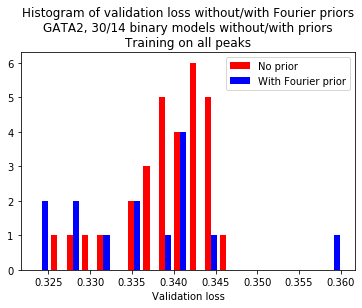

In [8]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_bin_val_losses.values())), np.array(list(prior_bin_val_losses.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With Fourier prior"], color=["red", "blue"])
title = "Histogram of validation loss without/with Fourier priors"
title += "\nK562, %d/%d binary models without/with priors" % (len(noprior_bin_val_losses), len(prior_bin_val_losses))
title += "\nTraining on all peaks"
plt.title(title)
plt.xlabel("Validation loss")
plt.legend()

np_vals, p_vals = np.array(list(noprior_bin_val_losses.values())), np.array(list(prior_bin_val_losses.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print("Mean without priors: %f" % np.mean(np_vals))
print("Mean with priors: %f" % np.mean(p_vals))
print("One-sided t-test p: %f" % (p / 2))